In [9]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 数据加载和去除Unnameed字段
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test1.csv')
train = train.iloc[:, 1:]
test = test.iloc[:,1:]

# 去除数据探索发现问题的字段
col = train.columns.tolist()
remove_list = ['lan', 'os','label', 'sid']
for i in remove_list:
    col.remove(i)
features = train[col]
test_features = test[col]

# 对osv进行数据清洗
def osv_trans(x):
    x = str(x).replace('Android_', '').replace('Android ', '').replace('W', '')
    if str(x).find('.')>0:
        temp_index1 = x.find('.')
        if x.find(' ')>0:
            temp_index2 = x.find(' ')
        else:
            temp_index2 = len(x)
 
        if x.find('-')>0:
            temp_index2 = x.find('-')
            
        result = x[0:temp_index1] + '.' + x[temp_index1+1:temp_index2].replace('.', '')
        try:
            return float(result)
        except:
            print('有错误: '+x)
            return 0
    try:
        return float(x)
    except:
        print('有错误: '+x)
        return 0
features['osv'].fillna('8.1.0', inplace=True)
features['osv'] = features['osv'].apply(osv_trans)
test_features['osv'].fillna('8.1.0', inplace=True)
test_features['osv'] = test_features['osv'].apply(osv_trans)

# 对timestamp进行数据清洗与特征变换,
from datetime import datetime
features['timestamp'] = features['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
test_features['timestamp'] = test_features['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
temp = pd.DatetimeIndex(features['timestamp'])
features['year'] = temp.year
features['month'] = temp.month
features['day'] = temp.day
features['hour'] = temp.hour
features['minute'] = temp.minute
features['week_day'] = temp.weekday #星期几
start_time = features['timestamp'].min()
features['time_diff'] = features['timestamp'] - start_time
features['time_diff'] = features['time_diff'].dt.days + features['time_diff'].dt.seconds/3600/24
temp = pd.DatetimeIndex(test_features['timestamp'])
test_features['year'] = temp.year
test_features['month'] = temp.month
test_features['day'] = temp.day
test_features['hour'] = temp.hour
test_features['minute'] = temp.minute
test_features['week_day'] = temp.weekday #星期几 
test_features['time_diff'] = test_features['timestamp'] - start_time
test_features['time_diff'] = test_features['time_diff'].dt.days + test_features['time_diff'].dt.seconds/3600/24
features = features.drop(['timestamp'],axis = 1)
test_features = test_features.drop(['timestamp'],axis = 1)

# 对version进行数据清洗与特征变换
def version_trans(x):
    if x=='V3':
        return 3
    if x=='v1':
        return 1
    if x=='P_Final_6':
        return 6
    if x=='V6':
        return 6
    if x=='GA3':
        return 3
    if x=='GA2':
        return 2
    if x=='V2':
        return 2
    if x=='50':
        return 5
    return int(x)
features['version'] = features['version'].apply(version_trans)
test_features['version'] = test_features['version'].apply(version_trans)
features['version'] = features['version'].astype('int')
test_features['version'] = test_features['version'].astype('int')

# 对lan进行数据清洗与特征变换 对于有缺失的lan 设置为22    
lan_map = {'zh-CN': 1, 'zh_CN':2, 'Zh-CN': 3, 'zh-cn': 4, 'zh_CN_#Hans':5, 'zh': 6, 'ZH': 7, 'cn':8, 'CN':9, 'zh-HK': 10, 'tw': 11, 'TW': 12, 'zh-TW': 13,             'zh-MO':14, 'en':15, 'en-GB': 16, 'en-US': 17, 'ko': 18, 'ja': 19, 'it': 20, 'mi':21} 
train['lan'] = train['lan'].map(lan_map)
test['lan'] = test['lan'].map(lan_map)
train['lan'].fillna(22, inplace=True)
test['lan'].fillna(22, inplace=True)

# 构造面积特征和构造相除特征
features['dev_area'] = features['dev_height'] * features['dev_width']
test_features['dev_area'] = test_features['dev_height'] * test_features['dev_width']
features['dev_rato'] = features['dev_height'] / features['dev_width']
test_features['dev_rato'] = test_features['dev_height'] / test_features['dev_width']
# APP版本与操作系统版本差
features['version_osv'] = features['osv'] - features['version']
test_features['version_osv'] = test_features['osv'] - test_features['version']

# 对fea_hash与fea1_hash特征变换
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features['fea_hash_len'] = test_features['fea_hash'].map(lambda x: len(str(x)))
test_features['fea1_hash_len'] = test_features['fea1_hash'].map(lambda x: len(str(x)))
test_features['fea_hash'] = test_features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features['fea1_hash'] = test_features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))

有错误: f073b_changxiang_v01_b1b8_20180915
有错误: %E6%B1%9F%E7%81%B5OS+5.0
有错误: GIONEE_YNGA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   android_id     500000 non-null  int64  
 1   apptype        500000 non-null  int64  
 2   carrier        500000 non-null  float64
 3   dev_height     500000 non-null  float64
 4   dev_ppi        500000 non-null  float64
 5   dev_width      500000 non-null  float64
 6   media_id       500000 non-null  int64  
 7   ntt            500000 non-null  float64
 8   osv            500000 non-null  float64
 9   package        500000 non-null  int64  
 10  version        500000 non-null  int32  
 11  fea_hash       500000 non-null  int64  
 12  location       500000 non-null  int64  
 13  fea1_hash      500000 non-null  int64  
 14  cus_type       500000 non-null  int64  
 15  year           500000 non-null  

In [10]:
%%time
#lightgbm进行训练与预测
import xgboost as xgb
model_xgb = xgb.XGBClassifier(
            max_depth=15, learning_rate=0.05, n_estimators=5000, 
            objective='binary:logistic', tree_method='gpu_hist', 
            subsample=0.8, colsample_bytree=0.8, 
            min_child_samples=3, eval_metric='auc', reg_lambda=0.5
        )
model_xgb.fit(features,train['label'])
result_xgb = model.predict(test_features)
res = pd.DataFrame(test['sid'])
res['label'] = result_xgb
res.to_csv('./baselineV3.csv',index=False)
print("已完成")

[13:35:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_child_samples" } are not used.

已完成
Wall time: 5min 2s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

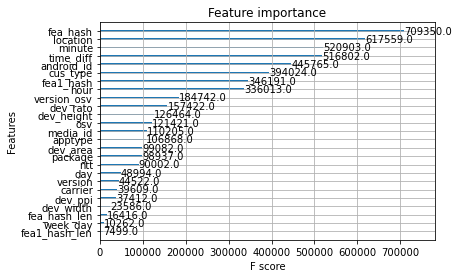

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model_xgb)